In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

## 报告数据标准化

In [2]:
data = json.load(open('data/conference/conference.json', encoding='utf-8', mode='r'))
reports = []
halls = set()
for report in data:
    title = report['title']
    institutions = report['institutions']
    if title and institutions:
        reports.append(report)
        halls.add(report['hall'])

hall_2_id = {h:i for i, h in enumerate(sorted(halls))}
id_2_hall = {i:h for h, i in hall_2_id.items()}
print(len(reports), reports[0], halls)
print(hall_2_id)

481 {'date': '2021-10-16 星期六', 'hall': '黄龙水晶宫', 'host': '陆锋', 'topic': '09:10-10:40 | 特邀报告', 'time': '09:10-09:40', 'title': '全球位置服务网关键技术与研究进展', 'reporters': '龚健雅 院士', 'institutions': '武汉大学'} {'分会场四', '分会场十', '分会场十二', '分会场六', '分会场七', '分会场九', '分会场十一', '分会场一', '分会场五', '分会场三', '分会场二', '黄龙水晶宫', '分会场八', '分会场十四', '分会场十三'}
{'分会场一': 0, '分会场七': 1, '分会场三': 2, '分会场九': 3, '分会场二': 4, '分会场五': 5, '分会场八': 6, '分会场六': 7, '分会场十': 8, '分会场十一': 9, '分会场十三': 10, '分会场十二': 11, '分会场十四': 12, '分会场四': 13, '黄龙水晶宫': 14}


### 报告时间与会场标准化
需要提一下，有重复报告，这里我们采用去重的方法解决

In [3]:
from datetime import datetime
time_format = '%Y-%m-%d %H:%M'
base_time = datetime(2021, 10, 15)
new_data = []
start_time_set = set()
title_set = set()
for report in reports:
    title = report['title']
    if title in title_set: 
        print(title)
        continue
    title_set.add(title)
    date = report['date']
    time = report['time']
    hall = report['hall']
    topic = report['topic']
    topic = topic.split('|')[-1].split('：')[-1].strip()
    date = date.split(' ')[0]
    start, end = time.split('-')
    start_time = date + ' ' + start # datetime.strptime(date + ' ' + start, time_format)
    end_time = date + ' ' + end
    s_time = datetime.strptime(start_time, time_format) - base_time
    e_time = datetime.strptime(end_time, time_format) -  base_time
    hall_id = hall_2_id[hall]
    report['date'] = date
    report['start_time'] = int(s_time.total_seconds())
    report['end_time'] = int(e_time.total_seconds())
    report['hall_id'] = hall_id
    report['topic'] = topic
    start_time_set.add(start_time)
    new_data.append(report)
json.dump(new_data, open('data/conference/standard_conference_data.json', 'w', encoding='utf-8'), ensure_ascii=False)
print(new_data[0])
print(len(title_set), len(reports))

康巴藏区藏传佛教寺院的空间布局特征及其影响因素
基于GPS轨迹的西藏骑行游客时空行为分析
基于轨迹大数据的游客行为研究：总结、局限与展望
{'date': '2021-10-16', 'hall': '黄龙水晶宫', 'host': '陆锋', 'topic': '特邀报告', 'time': '09:10-09:40', 'title': '全球位置服务网关键技术与研究进展', 'reporters': '龚健雅 院士', 'institutions': '武汉大学', 'start_time': 119400, 'end_time': 121200, 'hall_id': 14}
478 481


#### 按时间段分组

In [4]:
min_delta = 600
time_spans = []
sorted_data = sorted(new_data, key=lambda x: x['start_time']) # 按开始时间排序
t = sorted_data[0]['start_time']
group = 0
group_dict = defaultdict(lambda: list())
# group_dict[group] = []
topic_2_report = defaultdict(lambda: list())
id_2_report = dict()
topic_2_report_id = defaultdict(lambda: list())
for i, report in enumerate(sorted_data):
    s_time = int(report['start_time'])
    e_time = int(report['end_time'])
    topic = report['topic']
    delta = s_time - t

    if delta > min_delta:
        group += 1
        t = s_time
    group_dict[group].append(i)   
    report['time_group'] = group
    report['id'] = i
    topic_2_report[topic].append((i, report['title']))
    topic_2_report_id[topic].append(i)
    id_2_report[i] = report['title']
print(group)
json.dump(sorted_data, open(f'data/conference/grouped_conference_data_{min_delta}.json', 'w', encoding='utf-8'), ensure_ascii=False)
    

47


In [5]:
dict(topic_2_report_id).keys()

dict_keys(['特邀报告', '大会报告', '轨迹数据挖掘', '海洋大数据挖掘分析与应用', '地理时空建模', '青藏高原资源环境遥感与GIS', '地理空间认知', '地理空间智能分析与计算', '地理信息共享与互操作', '全空间信息系统原理与技术', '地理信息安全与共享', '空间数据组织与管理', 'GIS与行星遥感', '时间序列遥感动态监测', '三维GIS与虚拟地理环境', '青年学者分论坛一', '空间统计与时空推理', '地理大数据挖掘与时空模式发现', '时空模拟与预测', '室内构图与应用', '智慧城市与数字化改革', '大数据与地球信息科学', '青年学者分论坛三', '青年学者分论坛四', '青年学者分论坛五', '空间回归方法及大数据应用', '遥感数据处理与信息获取', '城市洪涝时空建模与模拟', '点云智能处理', '青年学者分论坛二', '时空大数据与粤港澳城市群协同发展', '传染病地理计算', '遥感智能应用', '人文、社会与GIS可持续发展', '地理知识图谱', '研究生论文竞赛（上半场）', '青年学者分论坛六', '青年学者分论坛八', '青年学者分论坛十', '人群动态观测（一）', '多模态遥感信息融合', '青年教师论文竞赛', '历史GIS（一）', '青年学者分论坛十二', '时空大数据与可持续发展', '全球综合观测与服务共享', '遥感变化检测与地图更新', '云计算与时空大数据', '地理信息多尺度表达', '研究生论文竞赛（下半场）', '青年学者分论坛七', '青年学者分论坛九', '青年学者分论坛十一', '人群动态观测（二）', '青年学者分论坛十四', '地图设计与创意', '历史GIS（二）', '青年学者分论坛十三'])

最长组

In [6]:
group_max_len = max([len(g) for k, g in group_dict.items()])
print(group_max_len)

23


### 生成测试数据

In [7]:
test_keywords = ['时空大数据', '人工智能', '粤港澳大湾区', '空间可达性', '光学遥感',  
                    '轨迹数据挖掘', '时空模拟与预测', '地理时空建模', '遥感变化检测与地图更新', '地理信息共享与互操作'] # 五个抽取的关键词，五个专题名
with open('data/text_match/predict.jl', 'w', encoding='utf-8') as writer:
    for keyword in test_keywords:
        for report in sorted_data:
            writer.write(json.dumps({'title': report['title'], 'keywords': [keyword]}, ensure_ascii=False))
            writer.write('\n')

In [8]:
test_topics = ['轨迹数据挖掘', '海洋大数据挖掘分析与应用', '地理时空建模', '青藏高原资源环境遥感与GIS', 
    '地理空间认知', '地理空间智能分析与计算', '地理信息共享与互操作', '全空间信息系统原理与技术', 
    '地理信息安全与共享', '空间数据组织与管理', 'GIS与行星遥感', '时间序列遥感动态监测', '三维GIS与虚拟地理环境', 
    '空间统计与时空推理', '地理大数据挖掘与时空模式发现', '时空模拟与预测', '室内构图与应用', '智慧城市与数字化改革', 
    '大数据与地球信息科学', '空间回归方法及大数据应用', '遥感数据处理与信息获取', '城市洪涝时空建模与模拟', '点云智能处理', 
    '时空大数据与粤港澳城市群协同发展', '传染病地理计算', '遥感智能应用', '人文、社会与GIS可持续发展', '地理知识图谱', 
    '多模态遥感信息融合', '时空大数据与可持续发展', '全球综合观测与服务共享', '遥感变化检测与地图更新', 
    '云计算与时空大数据', '地理信息多尺度表达'
]
topic_ids = [1, 3, 7, 16, 17, 21, 22, 24, 27, 28]
with open('data/text_match/predict_topics.jl', 'w', encoding='utf-8') as writer:
    for keyword in test_topics:
        for report in sorted_data:
            writer.write(json.dumps({'title': report['title'], 'keywords': [keyword]}, ensure_ascii=False))
            writer.write('\n')
# ['轨迹数据挖掘', '时空模拟与预测', '地理时空建模', '遥感变化检测与地图更新', '地理信息共享与互操作']
test_data = {test_topics[topic_id]: topic_2_report_id[test_topics[topic_id]] for topic_id in topic_ids}

### 预测数据读取

In [9]:
prob_matrix = np.zeros((len(sorted_data), len(test_topics)), dtype=float)
with open('outputs/text_match/predictions/bert_bert_wwm_ext_2_prediction_text_matching.jl', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        d_json = json.loads(line.strip())
        prob = float(d_json['prob'])
        col = i // len(sorted_data)
        row = i - col * len(sorted_data)
        prob_matrix[row, col] = prob
    assert i == len(sorted_data) * len(test_topics) - 1

#### 查看与关键词最匹配的标题

In [10]:
# ith = 0
# keyword = test_topics[ith]

recalls = []
bert_topic_recalls = dict()
for ith in topic_ids:
    keyword = test_topics[ith]
    probs = prob_matrix[:, ith]
    ranks = np.argsort(-probs) # 由于默认使用升序，所以使用负号
    #print(keyword, ':')
    gold_report_ids = topic_2_report_id[keyword]
    count = 0
    for i, r in enumerate(ranks[:20]): # 看前十个
        report = sorted_data[r]
        if r in gold_report_ids:
            count += 1
        # print(report['title'], probs[r])
    recall = count / len(gold_report_ids)
    bert_topic_recalls[keyword] = recall
    #if recall >= 0.65:
    print('{} {} 召回率: {:.4f}'.format(ith, keyword, recall))
    recalls.append(recall)

    # print('gold reports:')
    # gold_reports = topic_2_report.get(keyword, [])
    # for i, report in gold_reports:
    #     print(report)
print(sum(recalls) / len(recalls))


1 海洋大数据挖掘分析与应用 召回率: 0.8571
3 青藏高原资源环境遥感与GIS 召回率: 0.7143
7 全空间信息系统原理与技术 召回率: 0.8333
16 室内构图与应用 召回率: 0.8571
17 智慧城市与数字化改革 召回率: 1.0000
21 城市洪涝时空建模与模拟 召回率: 0.8750
22 点云智能处理 召回率: 1.0000
24 传染病地理计算 召回率: 0.6667
27 地理知识图谱 召回率: 0.7143
28 多模态遥感信息融合 召回率: 0.8571
0.8375


## 概率转移矩阵中参数的确定

### 空间距离因素

In [50]:
area1 = {'分会场一', '分会场二', '分会场三', '分会场四', '黄龙水晶宫'}
area2 = {'分会场五', '分会场六', '分会场七', '分会场八', '分会场九'}
area3 = {'分会场十', '分会场十一', '分会场十二', '分会场十三', '分会场十四'}
distance_dict = {
    '11': 2, '22': 3, '33': 3,
    '12': 10, '21': 10, '13': 15, '31':15,
    '23': 20, '32': 20
}
distance_matrix = np.zeros((len(hall_2_id), len(hall_2_id)), dtype=float)
hall_2_area = {h: 1 for h in area1}
hall_2_area.update({h: 2 for h in area2})
hall_2_area.update({h: 3 for h in area3})

for i in range(len(hall_2_id)):
    from_hall = id_2_hall[i]
    from_area = hall_2_area[from_hall]
    distance_matrix[i, i] = 1
    for j in range(i):
        to_hall = id_2_hall[j]
        to_area = hall_2_area[to_hall]
        dis = distance_dict[str(from_area)+str(to_area)]
        distance_matrix[i, j] = distance_matrix[j, i] = dis
print(distance_matrix)

[[ 1. 10.  2. 10.  2. 10. 10. 10. 15. 15. 15. 15. 15.  2.  2.]
 [10.  1. 10.  3. 10.  3.  3.  3. 20. 20. 20. 20. 20. 10. 10.]
 [ 2. 10.  1. 10.  2. 10. 10. 10. 15. 15. 15. 15. 15.  2.  2.]
 [10.  3. 10.  1. 10.  3.  3.  3. 20. 20. 20. 20. 20. 10. 10.]
 [ 2. 10.  2. 10.  1. 10. 10. 10. 15. 15. 15. 15. 15.  2.  2.]
 [10.  3. 10.  3. 10.  1.  3.  3. 20. 20. 20. 20. 20. 10. 10.]
 [10.  3. 10.  3. 10.  3.  1.  3. 20. 20. 20. 20. 20. 10. 10.]
 [10.  3. 10.  3. 10.  3.  3.  1. 20. 20. 20. 20. 20. 10. 10.]
 [15. 20. 15. 20. 15. 20. 20. 20.  1.  3.  3.  3.  3. 15. 15.]
 [15. 20. 15. 20. 15. 20. 20. 20.  3.  1.  3.  3.  3. 15. 15.]
 [15. 20. 15. 20. 15. 20. 20. 20.  3.  3.  1.  3.  3. 15. 15.]
 [15. 20. 15. 20. 15. 20. 20. 20.  3.  3.  3.  1.  3. 15. 15.]
 [15. 20. 15. 20. 15. 20. 20. 20.  3.  3.  3.  3.  1. 15. 15.]
 [ 2. 10.  2. 10.  2. 10. 10. 10. 15. 15. 15. 15. 15.  1.  2.]
 [ 2. 10.  2. 10.  2. 10. 10. 10. 15. 15. 15. 15. 15.  2.  1.]]


### 时间间隔因素

In [ ]:
len(start_time_set)
transfer_matrices = []
for i in range(len(group_dict)-1):
    transfer_mat = np.zeros((group_max_len, group_max_len), dtype=float)
    from_group = group_dict[i]
    to_group = group_dict[i+1]
    for i, from_r in enumerate(from_group):
        from_hall_id = sorted_data[from_r]['hall_id']
        for j, to_r in enumerate(to_group):
            to_hall_id = sorted_data[to_r]['hall_id']
            distance = distance_matrix[from_hall_id, to_hall_id]
            transfer_mat[i, j] = 1 / distance # 距离的倒数
    transfer_matrices.append(transfer_mat)
print(transfer_matrices[9])

In [56]:
len(transfer_matrices)

47

### 条件随机场

In [4]:
from typing import Tuple, List
def step(mu_prev: np.ndarray,
         emission_probs: np.ndarray,
         transition_probs: np.ndarray,
         observed_state: int) -> Tuple[np.ndarray, np.ndarray]:
    """Runs one step of the Viterbi algorithm.
    
    Args:
        mu_prev: probability distribution with shape (num_hidden),
            the previous mu
        emission_probs: the emission probability matrix (num_hidden,
            num_observed)
        transition_probs: the transition probability matrix, with
            shape (num_hidden, num_hidden)
        observed_state: the observed state at the current step
    
    Returns:
        - the mu for the next step
        - the maximizing previous state, before the current state,
          as an int array with shape (num_hidden)
    """
    
    pre_max = mu_prev * transition_probs.T
    max_prev_states = np.argmax(pre_max, axis=1)
    max_vals = pre_max[np.arange(len(max_prev_states)), max_prev_states]
    mu_new = max_vals * emission_probs[:, observed_state]
    
    return mu_new, max_prev_states


def viterbi(emission_probs: np.ndarray,
            transition_probs: np.ndarray) -> Tuple[List[int], float]:
    """Runs the Viterbi algorithm to get the most likely state sequence.
    
    Args:
        emission_probs: the emission probability matrix (num_hidden,
            steps)
        transition_probs: the transition probability matrix, with
            shape (steps-1, num_hidden, num_hidden)
    
    Returns:
        - the most likely series of states
        - the joint probability of that series of states and the observed
    """
    
    # Runs the forward pass, storing the most likely previous state.
    assert emission_probs.shape[-1] - 1 == transition_probs.shape[0]
    mu = emission_probs[:, 0]
    all_prev_states = []
    for t in range(1, emission_probs.shape[-1]):
        mu, prevs = step(mu, emission_probs, transition_probs[t-1], t)
        all_prev_states.append(prevs)
    
    # Traces backwards to get the maximum likelihood sequence.
    state = np.argmax(mu)
    sequence_prob = mu[state]
    state_sequence = [state]
    for prev_states in all_prev_states[::-1]:
        state = prev_states[state]
        state_sequence.append(state)
    
    return state_sequence[::-1], sequence_prob

In [75]:
kw_i = 6 # 第几个 test_keywords
steps = len(group_dict)
num_hidden = group_max_len
transition_probs = np.array(transfer_matrices, dtype=float) # np.random.rand(steps-1, num_hidden, num_hidden)
emission_probs = np.full((num_hidden, steps), -1000, dtype=float) # (num_hidden, steps)
probs = prob_matrix[:, kw_i]
for g_id in range(len(group_dict)):
    group = group_dict[g_id]
    for ind, report_id in enumerate(group):
        emission_probs[ind, g_id] = probs[report_id]

seq, prob = viterbi(emission_probs, transition_probs)
print(seq, prob)

[0, 0, 0, 0, 0, 0, 0, 9, 10, 4, 1, 3, 9, 3, 6, 5, 2, 8, 8, 7, 3, 12, 4, 6, 6, 0, 19, 0, 0, 0, 4, 0, 11, 7, 9, 11, 14, 6, 4, 12, 1, 4, 0, 0, 0, 0, 0, 0] 1.6875989651340056e-11


#### 展示推荐序列

In [76]:
print(test_keywords[kw_i], ':')
for i_group, ind in enumerate(seq):
    report_id = group_dict[i_group][ind]
    selected_report = sorted_data[report_id]
    title = selected_report['title']
    date, time = selected_report['date'], selected_report['time']
    emi_prob = prob_matrix[report_id, kw_i]
    if emi_prob > 3:
        print(i_group, date+' '+time , title, emi_prob)

时空模拟与预测 :
7 2021-10-16 13:30-13:50 多粒度时空对象建模理论研究 3.290858507156372
8 2021-10-16 13:50-14:10 历史-现势一体的时空大数据管理 3.0428085327148438
9 2021-10-16 14:00-14:15 基于轨迹数据的城市内涝交通暴露性时空模拟 7.124446868896484
10 2021-10-16 14:15-14:30 基于眼动数据的人类空间导航行为模式识别与预测 3.5094242095947266
18 2021-10-16 16:30-16:50 时空信息预测：从线性假设到不变性假设 15.986931800842285
20 2021-10-16 16:50-17:05 两种时空模拟方法—贝叶斯最大熵和集成嵌套拉普拉斯—在江苏省土壤有机质制图中的应用 7.694623947143555
23 2021-10-16 17:35-17:50 城市洪涝灾害脆弱性的综合量化模型与时空模拟 10.590811729431152
26 2021-10-17 8:10-8:20 登革热时空预报模型 3.7622668743133545
30 2021-10-17 9:00-9:15 面向粤港澳大湾区的时空数据分析与综合模拟 3.81354022026062
31 2021-10-17 9:10-9:20 武汉新冠肺炎治愈患者时空行为分析 3.1768651008605957
38 2021-10-17 11:06-11:14 基于出租车轨迹数据的居民区房价分析与预测 4.899379253387451
39 2021-10-17 11:30-11:38 基于轨迹数据的城市交通信息转向级挖掘与预测 4.563422203063965


## 基于字符串的文本相似度计算

- The Dice similarity score is defined as twice the shared information (intersection) divided by sum of cardinalities. For two sets X and Y, the Dice similarity score is:
$$
dice(X, Y) = \frac{2 * |X \cap Y|}{|X| + |Y|}
$$

- The overlap coefficient is a similarity measure related to the Jaccard measure that measures the overlap between two sets, and is defined as the size of the intersection divided by the smaller of the size of the two sets. For two sets X and Y, the overlap coefficient is:
$$
overlap\_coefficient(X, Y) = \frac{|X \cap Y|}{\min(|X|, |Y|)}
$$

Note, however, that certain measures such as affine gap, Monge-Elkan, Needleman-Wunsch, Smith-Waterman and Soft TF/IDF do not have a get_sim_score method, because there is no straightforward way to normalize the raw scores of these measures into similarity scores in [0,1]

In [24]:
import py_stringmatching.similarity_measure as SM

In [ ]:

sim_model = {
    'Levenshtein': SM.levenshtein.Levenshtein(),
    'Jaro-Winkler': SM.jaro_winkler.JaroWinkler(),
    'Jaccard': SM.jaccard.Jaccard(),
    'Dice': SM.dice.Dice(),
    'OverlapCoefficient': SM.overlap_coefficient.OverlapCoefficient()
    
}
k_model_recalls = defaultdict(dict)
model_k_recalls = defaultdict(dict)
k_range = list(range(5, 35, 5))
for k in k_range:
    print(k)
    for i, (m_name, model) in enumerate(sim_model.items()):
        recalls = []
        for topic, report_ids in test_data.items():
            pairs = []
            for tid, title in id_2_report.items():
                if i < 2:
                    score = model.get_sim_score(topic, title)
                else:
                    score = model.get_sim_score(list(topic), list(title))
                pairs.append({'index': tid, 'score': score})
                #
            pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
            count = 0
            for pair in pairs[:k]:
                if pair['index'] in report_ids:
                    count += 1
                # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
            recall = count / len(report_ids)
            # print('{} 召回率: {:.4f}'.format(topic, recall))
            recalls.append(recall)

        print(m_name, sum(recalls) / len(recalls))
        model_k_recalls[m_name][k] = sum(recalls) / len(recalls)
        k_model_recalls[k][m_name] = sum(recalls) / len(recalls)
k_model_recalls = dict(k_model_recalls)
model_k_recalls = dict(model_k_recalls)

### 字符串相似度计算方法在取不同 k 值时的召回率

C:\Users\kobe\.conda\envs\forltp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


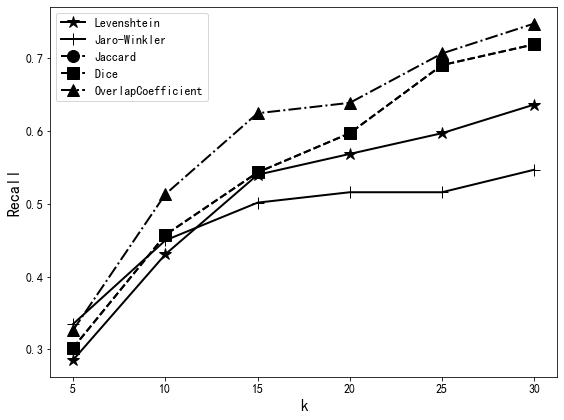

In [53]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MEDIUM_SIZE = 12
BIGGER_SIZE = 12
LARGE_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['axes.unicode_minus'] = False

stat_frame = pd.DataFrame(model_k_recalls).round(4)

fig, ax3 = plt.subplots(figsize=(8, 6))

ax3.set_xlabel('k')
ax3.set_xticklabels([0, 5, 10, 15, 20, 25, 30])
ax3.set_ylabel('Recall')

fmts = ['k*-', 'k+-', 'ko--', 'ks--', 'k^-.']
for i, (model_name, _) in enumerate(model_k_recalls.items()):
    y_data = stat_frame[model_name].tolist()
    ax3.plot(y_data, fmts[i], label=model_name, linewidth=2, markersize=12)

ax3.legend()

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/string_match_recalls.pdf', format='pdf')
plt.show()

### OverlapCoefficient 在各个 topic 上的召回

In [ ]:
model = SM.overlap_coefficient.OverlapCoefficient()

k_range = list(range(10, 35, 5))
k_recalls = dict()
for k in k_range:
    recalls = []
    for topic, report_ids in test_data.items():
        pairs = []
        for tid, title in id_2_report.items():
            
            score = model.get_sim_score(list(topic), list(title))
            
            pairs.append({'index': tid, 'score': score})
            #
        pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
        count = 0
        for pair in pairs[:k]:
            if pair['index'] in report_ids:
                count += 1
            # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
        recall = count / len(report_ids)
        # print('{} 召回率: {:.4f}'.format(topic, recall))
        recalls.append(recall)

    # print(m_name, sum(recalls) / len(recalls))
    k_recalls[k] = recalls
    
print(k_recalls)

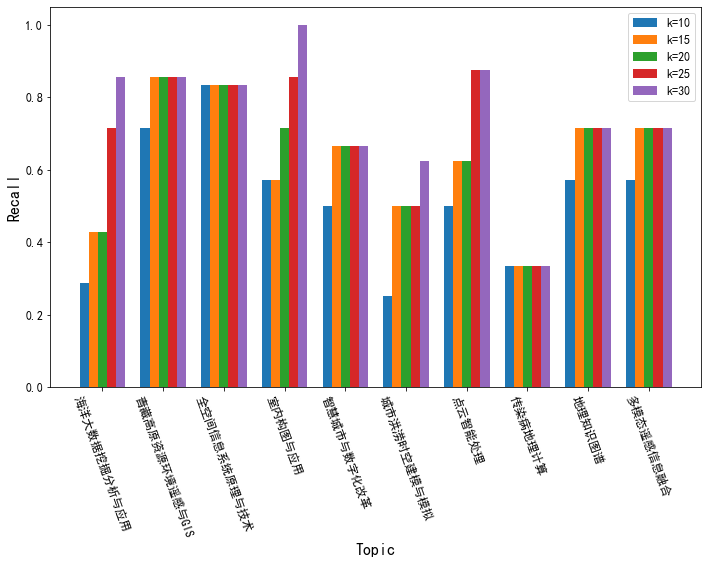

In [61]:
topics = [test_topics[ith] for ith in topic_ids]
topics, recalls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MEDIUM_SIZE = 12
BIGGER_SIZE = 12
LARGE_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# stat_dict = {
#     'BERT': [0.8571428571428571, 0.7142857142857143, 0.8333333333333334, 0.8571428571428571, 1.0, 0.875, 1.0, 0.6666666666666666, 0.7142857142857143, 0.8571428571428571]
# }

x_labels = topics #[str(i) for i in range(1, len(topic))]
x = np.arange(1, len(x_labels)+1)
width = 0.15

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体

fig, ax1 = plt.subplots(figsize=(10, 8))

rects0 = ax1.bar(x-2*width, k_recalls[10], width, label='k=10')
rects1 = ax1.bar(x-1*width, k_recalls[15], width, label='k=15')
rects2 = ax1.bar(x-0*width, k_recalls[20], width, label='k=20')
rects3 = ax1.bar(x+1*width, k_recalls[25], width, label='k=25')
rects4 = ax1.bar(x+2*width, k_recalls[30], width, label='k=30')

ax1.set_xlabel('Topic')
ax1.set_xticks(np.arange(1, len(topics)+1))
ax1.set_xticklabels(x_labels, rotation=290)
# ax1.set_xticks(x, x_labels)

ax1.set_ylabel('Recall')
ax1.legend()


fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('outputs/text_match/figs/string_match_topic_recalls.pdf', format='pdf')
plt.show()

## 基于词向量的文本相似度计算

In [35]:
from text2vec import Similarity
title_list = list(title_set)
# embedding_type: ['w2v', 'sbert']
# similarity_type: ['cosine', 'wmd']
sim_model = Similarity(similarity_type='wmd', embedding_type='w2v')

# for i, keyword in enumerate(test_keywords):
#     pairs = []
#     for j, title in enumerate(title_list):
#         score = sim_model.get_score(keyword, title)
#         pairs.append({'index': j, 'score': score})
#         #
#     pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
#     for pair in pairs[:20]:
#         print('{} \t {} \t Score: {:.4f}'.format(keyword, title_list[pair['index']], pair['score']))
recalls = []
for topic, report_ids in test_data.items():
    pairs = []
    for tid, title in id_2_report.items():
        score = sim_model.get_score(keyword, title)
        pairs.append({'index': tid, 'score': score})
        #
    pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
    count = 0
    for pair in pairs[:20]:
        if pair['index'] in report_ids:
            count += 1
    recall = count / len(report_ids)
        # print('{} \t {} \t Score: {:.4f}'.format(topic, id_2_report[pair['index']], pair['score']))
    print('{} 召回率: {:.4f}'.format(topic, recall))
    recalls.append(recall)
print(sum(recalls) / len(recalls))

2022-02-11 15:54:32.775 | DEBUG    | text2vec.word2vec:__init__:81 - Load w2v from w2v-light-tencent-chinese, spend 1.19 sec
2022-02-11 15:54:32.777 | DEBUG    | text2vec.word2vec:__init__:85 - Word count: 143613, emb size: 200
2022-02-11 15:54:32.778 | DEBUG    | text2vec.word2vec:__init__:86 - Set stopwords: ['--', '?', 'ZT', 'ZZ', "a's", 'able', 'about', 'above', 'according', 'accordingly'], count: 1396


海洋大数据挖掘分析与应用 召回率: 0.1429
青藏高原资源环境遥感与GIS 召回率: 0.0000
全空间信息系统原理与技术 召回率: 0.0000
室内构图与应用 召回率: 0.0000
智慧城市与数字化改革 召回率: 0.0000
城市洪涝时空建模与模拟 召回率: 0.0000
点云智能处理 召回率: 0.1250
传染病地理计算 召回率: 0.0000
地理知识图谱 召回率: 0.0000
多模态遥感信息融合 召回率: 0.1429
0.04107142857142857
